In [2]:
import numpy as np
from CIR import get_CIR
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import numpy as np
from simulation import Simulation, Contract
from torch.utils.data import TensorDataset, Dataset, DataLoader, Subset

from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [3]:
# Fix current device

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print('Current device:', device)

Current device: cuda


# Create dataset

In [4]:
# Generate CIR process

alpha = 0.6
b = 0.04
sigma = 0.14
v_0 = 0.04
years = 30
gamma = 0.4

sim = Simulation(alpha, b, sigma, v_0, years, gamma = gamma, seed=True)

In [6]:
### Create contracts

# Create a new contract every 380 days
arrival_times = np.array([i*366 for i in range(years) if i*380 < 365*years])
print('Simulation horizon: ', sim.TotPoints)
print('Arrival times: ', arrival_times)

contracts = []
for arrival_time in arrival_times:
    contract = Contract(arrival_time, sim)
    contracts.append(contract)

# Compute maximum number of simultaneously active contracts
max_n_active_contracts = 0
for t in range(sim.TotPoints):
    n_active_contracts = np.sum([contract.is_active(t) for contract in contracts])
    if n_active_contracts > max_n_active_contracts:
        max_n_active_contracts = n_active_contracts

print(f"Max number of simultaneously active contracts: {max_n_active_contracts}")


### Create dataset (X = features, y = targets)

n_contract_features = len(contracts[0].get_contract_features(0))
X = torch.zeros((sim.TotPoints, max_n_active_contracts*n_contract_features)) 
y_float = torch.ones(sim.TotPoints) 
y_fixed = torch.ones(sim.TotPoints)

for i_time, t in enumerate(range(sim.TotPoints-1)):
    active_contracts = [contract for contract in contracts if contract.is_active(t)]
    for i_contract, contract in enumerate(active_contracts):
        
        contract_features = contract.get_contract_features(t)
        X[i_time, i_contract*len(contract_features) : (i_contract+1)*len(contract_features)] = contract_features
        
        # The targets are summed across active contracts, so we get the net value across contracts
        # (e.g. net variation margin or net value of contracts)
        
        #COMMENTED: FOCUS ON SINGLE LEGS
        #y[i_time] += sim.MarkToMarketPrice(contract.delta, contract.t_0, t, contract.T)
        
        y_float[i_time] += np.log(sim.GetFloatingLeg(contract.t_0, t) )
        y_fixed[i_time] += np.log(sim.GetFixedLeg(contract.t_0, t, contract.T))
        

Simulation horizon:  10950
Arrival times:  [    0   366   732  1098  1464  1830  2196  2562  2928  3294  3660  4026
  4392  4758  5124  5490  5856  6222  6588  6954  7320  7686  8052  8418
  8784  9150  9516  9882 10248]
Max number of simultaneously active contracts: 1


In [7]:
# Train-test split

training_index = int(0.8 * X.shape[0])

CIRProcess = torch.tensor(sim.CIRProcess.reshape(-1,1)).to(torch.float32).to(device)

#Prepare both legs
y_float_train = y_float[:training_index]
y_fixed_train = y_fixed[:training_index]
X_train = X[:training_index, :]
CIR_train = CIRProcess[:training_index]

y_float_test = y_float[training_index:]
y_fixed_test = y_fixed[training_index:]
X_test = X[training_index:, :]
CIR_test = CIRProcess[training_index:]

In [8]:
def create_windows(features, targets_float, targets_fixed, r, lookback):
    """
    Windows the dataset
    """
    n_samples = features.shape[0] - lookback

    X_data = torch.zeros(n_samples, lookback, features.shape[1])
    y_float_data = torch.ones(n_samples, 1)
    y_fixed_data = torch.ones(n_samples, 1)
    r_data = torch.zeros(n_samples, 1)

    for i_sample in range(n_samples):

        X_data[i_sample, :] = features[i_sample : i_sample + lookback]   #it takes data in [i_sample, i_sample+lookback)
        y_float_data[i_sample, 0] = targets_float[i_sample + lookback]   #it takes [i_sample + lookback] which is +1 time shifted w.r.t. the feature set
        y_fixed_data[i_sample, 0] = targets_fixed[i_sample + lookback]
        r_data[i_sample, 0] = r[i_sample + lookback]
        
    return X_data.to(torch.float32).to(device), y_float_data.to(torch.float32).to(device), y_fixed_data.to(torch.float32).to(device), r_data.to(torch.float32).to(device)
    

In [9]:
# Slice dataset into windows

lookback = 1
X_train, y_float_train, y_fixed_train, r_train = create_windows(X_train, y_float_train, y_fixed_train, CIR_train, lookback=lookback)
X_test, y_float_test, y_fixed_test, r_test = create_windows(X_test, y_float_test, y_fixed_test, CIR_test, lookback=lookback)


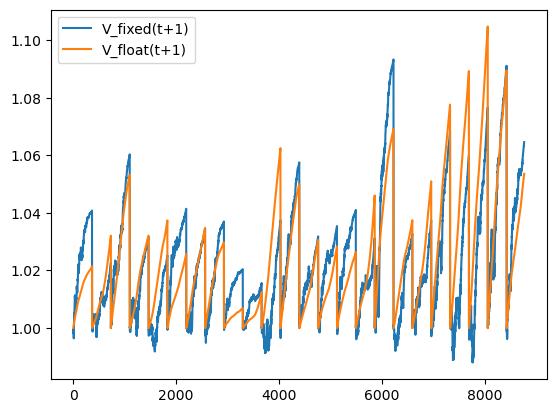

In [10]:
plt.plot(y_fixed_train.cpu(), label='V_fixed(t+1)')
plt.plot(y_float_train.cpu(), label='V_float(t+1)')
#plt.xlim(0, 500)
plt.legend()
plt.show()

In [11]:
#Build the pytorch datasets and dataloaders
train_dataset = TensorDataset(X_train.to(device), y_float_train.to(device), y_fixed_train.to(device), r_train.to(device))
test_dataset = TensorDataset(X_test.to(device), y_float_test.to(device), y_fixed_test.to(device), r_test.to(device))

loader = DataLoader(train_dataset, shuffle=True, batch_size=len(train_dataset))
loader_test = DataLoader(test_dataset, shuffle=True, batch_size = len(test_dataset))

In [20]:
#define the model
class model(nn.Module):

    def __init__(self):
        super(model, self).__init__()

        input_size = 2
        lstm_hidden_size = 5
        lstm_n_layers = 1
        regressor_hidden_size = 32
        self.name=regressor_hidden_size

        self.lstm = torch.nn.RNN(input_size=input_size, 
                             hidden_size=lstm_hidden_size, 
                             num_layers=lstm_n_layers)
        
        #Il +1 è perchè facciamo il concat con il reference interest rate
        self.regressor = nn.Sequential(nn.Linear(lstm_hidden_size+1, regressor_hidden_size),
                                       nn.ReLU(),
                                       nn.Linear(regressor_hidden_size, regressor_hidden_size),
                                       nn.ReLU(),
                                       nn.Linear(regressor_hidden_size, 1))
        
        self.fnn = nn.Sequential(nn.Linear(input_size+1, 64),
                                       nn.ReLU(),
                                       nn.Linear(64, 64),
                                       nn.ReLU(),
                                       nn.Linear(64, 1))
        
        self.reset_parameters()

    def forward(self, x, r):

#         lstm_hidden, _ = self.lstm(x)
#         return self.regressor(torch.squeeze(torch.cat([lstm_hidden[:,-1,:], r],dim=1)))

        return self.fnn(torch.cat([x, r.reshape(-1, x.shape[1], 1)], dim=2))
    
    def reset_parameters(self):

        self.lstm.reset_parameters()
        for layer in [self.regressor]:
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
                
    def do_epoch(self, loader, criterion, optimizer, training=True):
        """
        Trains the model over the batches for an epoch
        """

        #Instantiate a temp variable that tracks the average loss for the batches
        temp_loss = 0

        #Loop over data batches
        for X_batch, y_float_batch, y_fixed_batch, r_batch in loader:

            #.forward() method of the model, will output both V_float and V_fixed
            y_pred = self(X_batch, r_batch)
            #y_float_pred = y_pred
            y_fixed_pred = y_pred

            #y_float_pred, y_fixed_pred = y_pred[:,0], y_pred[:,1]

            #Compute the loss - FOCUS ON FIXED LEG
            loss = criterion(y_fixed_pred.squeeze(), y_fixed_batch.squeeze()) #+ criterion(y_fixed_pred, y_fixed_batch.squeeze())

            #If we are actually training the model instead of performing validation
            if training:

                #Backpropagation
                loss.backward()

                #Optimizer step
                optimizer.step() 
                optimizer.zero_grad()

            #Track the batch loss
            temp_loss += loss.item()

        #Take the average loss over the batches
        return temp_loss / len(loader)

In [21]:
#Let's get towards the training:

lr = 2e-3                        #Learning rate
criterion = nn.MSELoss()           #Loss function

#Define the model
mymodel = model().to(device)    

#optimizer & scheduler
optimizer = torch.optim.Adam(mymodel.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100*i for i in range(100)], gamma=1.)

n_epochs = 5000                   #Number of epochs

#Early stopping parameters
patience = 30                      #Number of consecutive epochs to wait for improvement

In [22]:
#Early stopping class
class EarlyStopping:
    
    def __init__(self, patience):
        self.patience = patience
        self.counter = 0
        self.best_score = 10
        self.early_stop = False

    def __call__(self, val_loss, model):
    
        if val_loss > self.best_score:

            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:

            self.best_score = val_loss
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), f'temp_state_dict{mymodel.name}.pt')

In [23]:
#Define two lists to store training record
training_loss = []
validation_loss = []
lrs = []

#Define a tqdm loop to get a nice progress bar
loop = tqdm(range(n_epochs))

#Define an early stopping object
early_stopping = EarlyStopping(patience)

for epoch in loop:

    #Set model in training mode
    mymodel.train()

    #Perform an epoch of training
    train_loss = mymodel.do_epoch(loader, criterion, optimizer)

    #Scheduler step
    scheduler.step()

    #Track the average over the batches
    training_loss.append(train_loss)

    
    #Validation every 50 epochs
    if epoch % 50 ==0:

        with torch.no_grad():
            #Set the model in eval mod
            mymodel.eval()

            test_loss = mymodel.do_epoch(loader_test, criterion, optimizer, training=False)

            #Track the average loss over the batches
            validation_loss.append(test_loss)

        #Check early stopping
        early_stopping(validation_loss[-1], mymodel)
        if early_stopping.early_stop:

            #Load the best set of parameters
            mymodel.load_state_dict(torch.load(f'temp_state_dict{mymodel.name}.pt'))
            print(f"Early stopping at epoch {epoch}.")
            break

    lrs.append(optimizer.param_groups[0]["lr"])
            
    #Give informations in the loop
    loop.set_postfix(loss = train_loss, val_loss = test_loss, best_val_loss = early_stopping.best_score, counter=early_stopping.counter, lr= lrs[-1])


  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
#Plot training record & learning rate schedule

plt.figure(figsize=(8,3))

plt.subplot(1,2,1)
plt.plot(training_loss, label='Train')
val_epochs= np.linspace(0, len(training_loss), num=len(validation_loss))
plt.plot(val_epochs, validation_loss, label='Val')
plt.yscale('log')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('log(MSE)')
plt.title('Training ')

plt.subplot(1,2,2)
plt.plot(lrs)
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('lr')
plt.title('Learning rate')

plt.tight_layout()
plt.show()

In [ ]:
#Makes the predictions
def predictions(dataset, model):

    dataloader = DataLoader(dataset, shuffle=False, batch_size=1)

    y_float_preds = torch.zeros(len(dataloader))
    y_fixed_preds = torch.zeros(len(dataloader))
    
    y_fixed_trues = torch.zeros(len(dataloader))
    y_float_trues = torch.zeros(len(dataloader))
    
    for i_sample, (X, y_float, y_fixed, r) in enumerate(dataloader):
        with torch.no_grad():
            
            y_preds = model(X,r).cpu()
            # FOCUS ON FIXED LEG
            y_fixed_preds[i_sample] = y_preds#, y_fixed_preds[i_sample] = y_preds[0], y_preds[1]
            y_float_trues[i_sample], y_fixed_trues[i_sample] = y_float.cpu(), y_fixed.cpu()
            
    return y_float_trues.numpy(), y_fixed_trues.numpy(), y_float_preds.numpy(), y_fixed_preds.numpy()

In [ ]:
#Get the predictions
train_float_labels, train_fixed_labels, train_float_predictions, train_fixed_predictions = predictions(train_dataset, mymodel)
test_float_labels, test_fixed_labels, test_float_predictions, test_fixed_predictions =predictions(test_dataset, mymodel)

In [ ]:
#Plot predictions (train)
plt.figure(figsize=(10,5))#, dpi=300)

#plt.subplot(1,2,1)
plt.plot(train_float_labels, 'r-', label='$V(t+1)$ label')
plt.plot(train_float_predictions, 'b-', label='Prediction')
#plt.xlim(10,20)
plt.grid()
plt.legend()
plt.title('Non-shifted float train')

#plt.subplot(1,2,2)
#plt.plot(train_float_labels[:-1], 'r.', label='$V(t+1)$ label')
#plt.plot(train_float_predictions[1:], 'bx', label='Prediction')
#plt.xlim(10,20)
#plt.grid()
#plt.legend()
#plt.title('Shifted')

#plt.tight_layout()
#plt.show()

In [ ]:
#Plot predictions (train)
plt.figure(figsize=(10,5))#, dpi=300)

#plt.subplot(1,2,1)
plt.plot(train_fixed_labels, 'r-', label='$V(t+1)$ label')
plt.plot(train_fixed_predictions, 'b--', label='Prediction')
plt.xlim(0,120)
plt.grid()
plt.legend()
plt.title('Non-shifted fixed train')

In [ ]:
#Plot predictions (train)
plt.figure(figsize=(10,5))#, dpi=300)

#plt.subplot(1,2,1)
plt.plot(test_float_labels, 'r-', label='$V(t+1)$ label')
plt.plot(test_float_predictions, 'b-', label='Prediction')
#plt.xlim(1000,1200)
plt.grid()
plt.legend()
plt.title('Non-shifted float test')

#plt.subplot(1,2,2)
#plt.plot(train_float_labels[:-1], 'r.', label='$V(t+1)$ label')
#plt.plot(train_float_predictions[1:], 'bx', label='Prediction')
#plt.xlim(10,20)
#plt.grid()
#plt.legend()
#plt.title('Shifted')

#plt.tight_layout()
#plt.show()

In [ ]:
#Plot predictions (train)
plt.figure(figsize=(10,5))#, dpi=300)

#plt.subplot(1,2,1)
plt.plot((test_fixed_labels), 'r-', label='$V(t+1)$ label')
plt.plot((test_fixed_predictions), 'b--', label='Prediction')
#plt.xlim(120,200)
plt.grid()
plt.legend()
plt.title('Non-shifted fixed test')

#plt.subplot(1,2,2)
#plt.plot(train_float_labels[:-1], 'r.', label='$V(t+1)$ label')
#plt.plot(train_float_predictions[1:], 'bx', label='Prediction')
#plt.xlim(10,20)
#plt.grid()
#plt.legend()
#plt.title('Shifted')

#plt.tight_layout()
#plt.show()

In [ ]:
#Plot predictions (train)
plt.figure(figsize=(10,5))#, dpi=300)

#plt.subplot(1,2,1)
plt.plot(test_fixed_labels[:-1], 'r-', label='$V(t+1)$ label')
plt.plot(test_fixed_predictions[1:], 'b-', label='Prediction')
plt.xlim(160,300)
plt.grid()
plt.legend()
plt.title('shifted fixed test')

#plt.subplot(1,2,2)
#plt.plot(train_float_labels[:-1], 'r.', label='$V(t+1)$ label')
#plt.plot(train_float_predictions[1:], 'bx', label='Prediction')
#plt.xlim(10,20)
#plt.grid()
#plt.legend()
#plt.title('Shifted')

#plt.tight_layout()
#plt.show()

In [ ]:
#Plot predictions (test)
plt.figure(figsize=(6,3), dpi=300)

plt.subplot(1,2,1)
plt.plot(test_float_labels, 'r.', label='$V(t+1)$ label')
plt.plot(test_float_predictions, 'bx', label='Prediction')
#plt.xlim(100,150)
plt.grid()
plt.legend()
plt.title('Non-shifted')

plt.subplot(1,2,2)
plt.plot(test_labels[:-1], 'r.', label='$V(t+1)$ label')
plt.plot(test_predictions[1:], 'bx', label='Prediction')
#plt.xlim(100,150)
plt.grid()
plt.legend()
plt.title('Shifted')

plt.tight_layout()
plt.show()

If I try to compute the loss between targets and labels i find, as expected, the same best val loss I observed during training:

However, If i shift the arrays I find a better loss

In [ ]:
criterion(torch.tensor(test_fixed_labels), torch.tensor(test_fixed_predictions))

In [ ]:
criterion(torch.tensor(test_fixed_labels[:-1]), torch.tensor(test_fixed_predictions[1:]))